<a href="https://colab.research.google.com/github/Yash-Kamtekar/Ansible/blob/main/3_layer_deep_neural_network_for_non_linear_regression_withotu_using_pytorch_builtin_layer_functionality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3 layer Deep Neural Network for non linear Relu without using pytorch builtin layer functionality**

import libraries

In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import math

**Prepare Data**

In [9]:
# 3 Dimension non-linear input data

n = 200
d = 3
x = torch.rand(n,d)
weights_true = torch.tensor([[2, 1,-1],[3,0,-1]]).T
bias_true = torch.tensor([[0.5],[0.1]])

y_true = torch.matmul((x ** 2).float() , weights_true.float()) + torch.matmul(x.float() , weights_true.float()) + bias_true.T.float()
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: torch.Size([200, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2, 1]), y: torch.Size([200, 2])


**Visualizing the data generated using TSNE**

In [10]:
from sklearn.manifold import TSNE
view = TSNE(n_components=2, n_jobs=5).fit_transform(x)
view.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(200, 2)

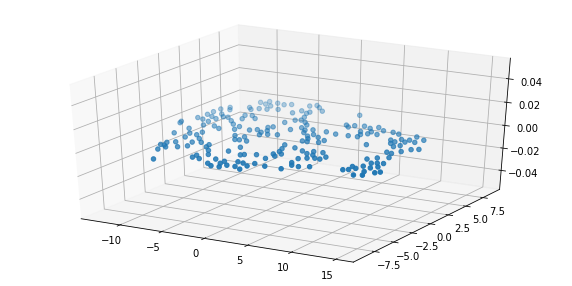

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#y_pred = y_pred.astype('int')
fig = plt.figure(figsize=(10,5))
tsne = fig.add_subplot(111, projection='3d')
tsne.scatter(*zip(*view))
plt.show()

**MSE**

In [13]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient

**Linear layer**

In [14]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden) * math.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.matmul(x, self.weights) + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = torch.matmul(self.x.T, gradient)
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = torch.matmul(gradient, self.weights.T)
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

**Adding non-linear activation function reLu**

In [15]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

**Model class**

In [16]:
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

**Calculating the loss**

In [17]:
loss = MSE()
model = TorchModel(d, 4)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(2.9337)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [19]:
def plot_3d(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

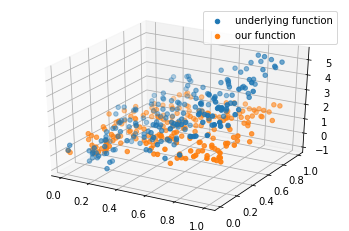

In [21]:
plot_3d(x, y_true, model(x_tensor).detach())

In [22]:
loss = MSE()
model = TorchModel(d, 10)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.01)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(2.2287)
tensor(2.1578)


In [23]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.01, num_epochs=70)

Epoch 0, loss 2.157764434814453
Epoch 1, loss 2.103973150253296
Epoch 2, loss 2.0625157356262207
Epoch 3, loss 2.0297493934631348
Epoch 4, loss 2.0030133724212646
Epoch 5, loss 1.9804071187973022
Epoch 6, loss 1.9605975151062012
Epoch 7, loss 1.9426645040512085
Epoch 8, loss 1.9259806871414185
Epoch 9, loss 1.9101229906082153
Epoch 10, loss 1.894808292388916
Epoch 11, loss 1.879848599433899
Epoch 12, loss 1.8651187419891357
Epoch 13, loss 1.8505367040634155
Epoch 14, loss 1.8360486030578613
Epoch 15, loss 1.8216183185577393
Epoch 16, loss 1.807222604751587
Epoch 17, loss 1.7928457260131836
Epoch 18, loss 1.7784773111343384
Epoch 19, loss 1.7641100883483887
Epoch 20, loss 1.7497398853302002
Epoch 21, loss 1.7353625297546387
Epoch 22, loss 1.7209765911102295
Epoch 23, loss 1.7065796852111816
Epoch 24, loss 1.6921714544296265
Epoch 25, loss 1.677750587463379
Epoch 26, loss 1.6633166074752808
Epoch 27, loss 1.6488696336746216
Epoch 28, loss 1.634408712387085
Epoch 29, loss 1.61993420124053

In [24]:
def tsne_plot(view, y, y_pred=None):
  fig = plt.figure()
  tsne = fig.add_subplot(111, projection='3d')
  tsne.scatter(view[:, 0], view[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    tsne.scatter(view[:, 0], view[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

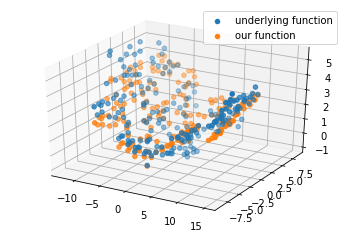

In [25]:
tsne_plot(view, y_true, model(x_tensor).detach())

** Data is overlapping even after training**